In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from typing import Tuple, Literal

In [20]:
# CSVファイルからデータを読み込む
def read_data_from_csv(filename):
    data = pd.read_csv(filename)
    return data


# 角速度を計算する（各コンポーネントごと）
def calculate_angular_velocity_component(
    data,
) -> Tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    gyro_x = data["gyro_x"]
    gyro_y = data["gyro_y"]
    gyro_z = data["gyro_z"]
    time = data["time"]
    angular_velocity_x = pd.DataFrame(
        {"time": time, "angular_velocity_x": np.sqrt(np.square(gyro_x))}
    )
    angular_velocity_y = pd.DataFrame(
        {"time": time, "angular_velocity_y": np.sqrt(np.square(gyro_y))}
    )
    angular_velocity_z = pd.DataFrame(
        {"time": time, "angular_velocity_z": np.sqrt(np.square(gyro_z))}
    )
    return angular_velocity_x, angular_velocity_y, angular_velocity_z


# 角速度を計算する（合成）
def calculate_angular_velocity_all(data) -> pd.DataFrame:
    gyro_x = data["gyro_x"]
    gyro_y = data["gyro_y"]
    gyro_z = data["gyro_z"]
    time = data["time"]
    angular_velocity = pd.DataFrame(
        {
            "time": time,
            "angular_velocity": np.sqrt(
                np.square(gyro_x) + np.square(gyro_y) + np.square(gyro_z)
            ),
        }
    )
    return angular_velocity


def apply_lowpass_filter(
    axis: Literal["x", "y", "z"], data, cutoff_freq, sampling_freq
):
    # バターワースフィルタを設計
    nyquist_freq = 0.5 * sampling_freq
    normal_cutoff = cutoff_freq / nyquist_freq
    b, a = butter(4, normal_cutoff, btype="low", analog=False)

    # フィルタを適用
    filtered_data = filtfilt(b, a, data[f"angular_velocity_{axis}"])

    # フィルタ後のデータを pd.DataFrame に変換
    filtered_df = pd.DataFrame(
        {"time": data["time"], "angular_velocity_x": filtered_data}
    )
    return filtered_df


def apply_highpass_filter(data, cutoff_freq, sampling_freq):
    # バターワースフィルタを設計
    nyquist_freq = 0.5 * sampling_freq
    normal_cutoff = cutoff_freq / nyquist_freq
    b, a = butter(4, normal_cutoff, btype="high", analog=False)

    # フィルタを適用
    filtered_data = filtfilt(b, a, data)
    return filtered_data


# 角速度を時間間隔ごとに積分して角度を計算する関数（単位時間ごと）
def integrate_angular_velocity_per_unit_time(
    axis: Literal["x", "y", "z"], angular_velocity_df, unit_time=0.7
):
    angular_velocity_df["time_unit"] = (
        angular_velocity_df["time"] // unit_time
    ).astype(int)

    # グループ化して角度を積分
    angle_df = (
        angular_velocity_df.groupby("time_unit")
        .apply(
            lambda df: pd.Series(
                {
                    "time": df["time"].iloc[0],  # 各グループの開始時間
                    "angle": np.trapz(df[f"angular_velocity_{axis}"], df["time"])
                    * (180 / np.pi),  # ラジアンから度に変換
                }
            )
        )
        .reset_index(drop=True)
    )

    return angle_df


# 角速度を時間間隔ごとに積分して角度を計算する関数
def integrate_angular_velocity(axis: Literal["x", "y", "z"], angular_velocity_df):
    time = angular_velocity_df["time"]
    angular_velocity = angular_velocity_df[
        f"angular_velocity_{axis}"
    ]  # ここは対象の角速度の列名に合わせる

    # 時間の差分を計算
    dt = np.diff(time, prepend=time[0])  # 最初の時間差分を0に設定
    angle = np.cumsum(angular_velocity * dt)  # 積分

    angle_df = pd.DataFrame({"time": time, "angle": angle * (180 / np.pi)})
    return angle_df


# データのプロット
def plot_data(raw_data: bytes, angular_velocity):
    plt.figure(figsize=(12, 6))

    # ジャイロセンサーデータのプロット
    plt.subplot(2, 1, 1)
    plt.plot(raw_data["time"], raw_data["gyro_x"], label="Gyro X")
    plt.plot(raw_data["time"], raw_data["gyro_y"], label="Gyro Y")
    plt.plot(raw_data["time"], raw_data["gyro_z"], label="Gyro Z")
    plt.title("Gyro Data")
    plt.xlabel("Time [s]")
    plt.ylabel("Gyro [rad/s]")
    plt.legend()

    # 角速度データのプロット
    plt.subplot(2, 1, 2)
    plt.plot(raw_data["time"], angular_velocity, label="Angular Velocity", color="r")
    plt.title("Angular Velocity")
    plt.xlabel("Time [s]")
    plt.ylabel("Angular Velocity [rad/s]")
    plt.legend()

    plt.tight_layout()
    plt.show()


def plot_data_angular_velocity(axis, raw_data, angular_velocity):
    plt.figure(figsize=(12, 6))

    # ジャイロセンサーデータのプロット
    plt.subplot(2, 1, 1)
    plt.plot(
        raw_data["time"], raw_data[f"angular_velocity_{axis}"], label=f"Gyro {axis}"
    )
    plt.title("Gyro Data")
    plt.xlabel("Time [s]")
    plt.ylabel("Gyro [rad/s]")
    plt.legend()

    # 角速度データのプロット
    plt.subplot(2, 1, 2)
    plt.plot(
        raw_data["time"],
        angular_velocity[f"angular_velocity_{axis}"],
        label="Angular Velocity",
        color="r",
    )
    plt.title("Angular Velocity")
    plt.xlabel("Time [s]")
    plt.ylabel("Angular Velocity [rad/s]")
    plt.legend()

    plt.tight_layout()
    plt.show()


# 角度データのプロット
def plot_angle(angle_df):
    plt.figure(figsize=(10, 6))
    plt.plot(angle_df["time"], angle_df["angle"], marker="o", linestyle="-")
    plt.title("Angle over Time")
    plt.xlabel("Time [s]")
    plt.ylabel("Angle [rad]")
    plt.grid(True)
    plt.show()

In [21]:
filename = "data/03/gyroscope.csv"
cutoff_freq = 2.0
sampling_freq = 100.0

data = read_data_from_csv(filename)
angular_velocity = calculate_angular_velocity_all(data)
angular_velocity_x, angular_velocity_y, angular_velocity_z = (
    calculate_angular_velocity_component(data)
)


filtered_lowpass_angular_velocity_x = apply_lowpass_filter(
    "x", angular_velocity_x, cutoff_freq, sampling_freq
)
filtered_lowpass_angular_velocity_y = apply_lowpass_filter(
    "y", angular_velocity_y, cutoff_freq, sampling_freq
)

filtered_lowpass_angular_velocity_z = apply_lowpass_filter(
    "z", angular_velocity_z, cutoff_freq, sampling_freq
)


angle = integrate_angular_velocity(axis="y", angular_velocity_df=angular_velocity_y)
angle_unit_time = integrate_angular_velocity_per_unit_time(
    axis="y", angular_velocity_df=angular_velocity_y
)

/var/folders/1w/52jfb36j6sg557p8z_gknglh0000gn/T/ipykernel_20605/2381200097.py:84: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(


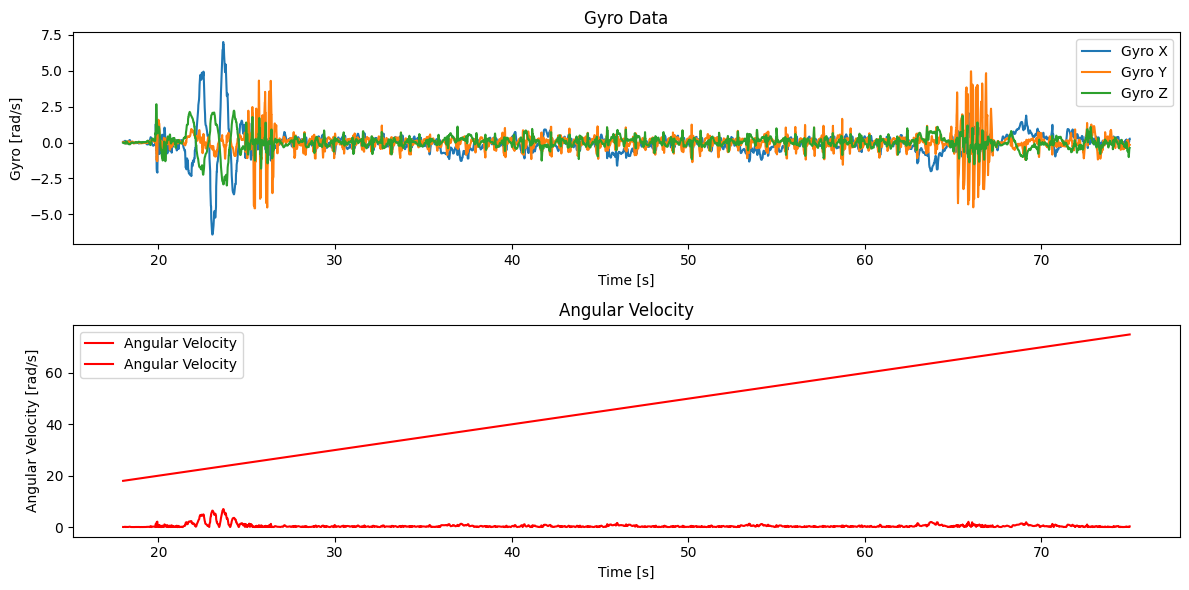

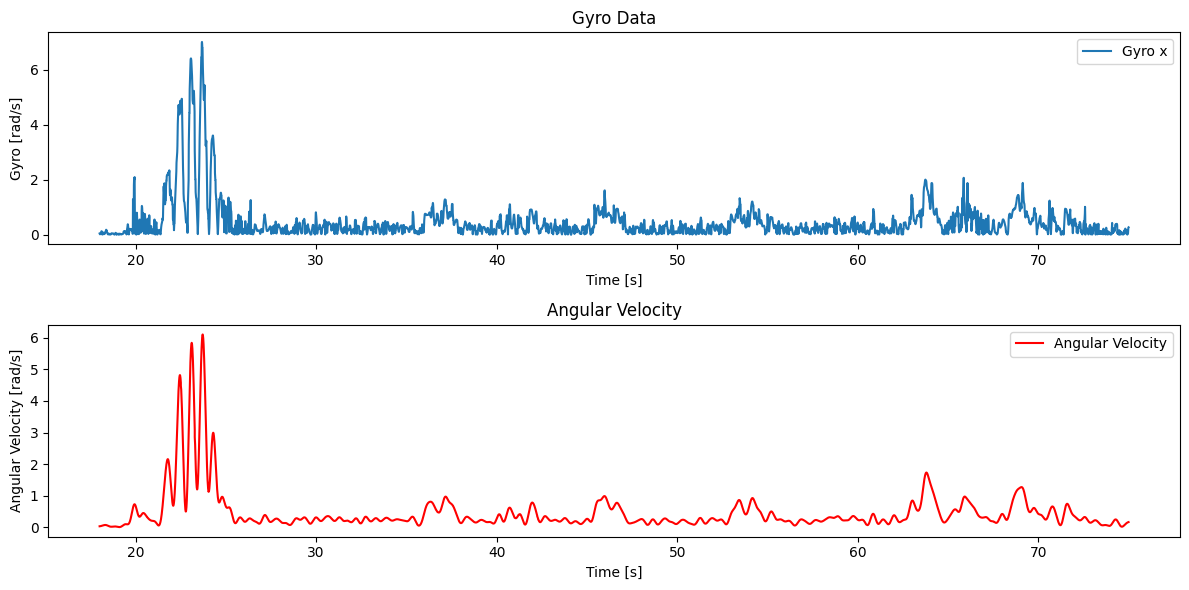

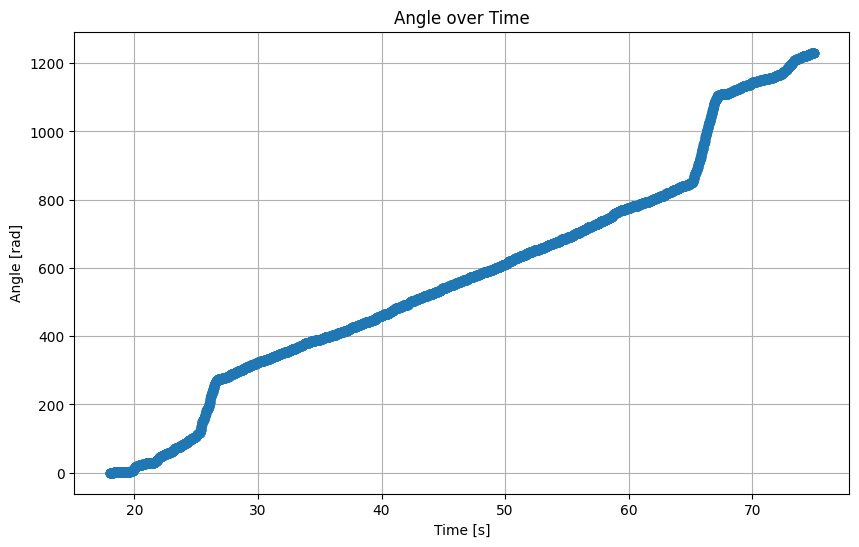

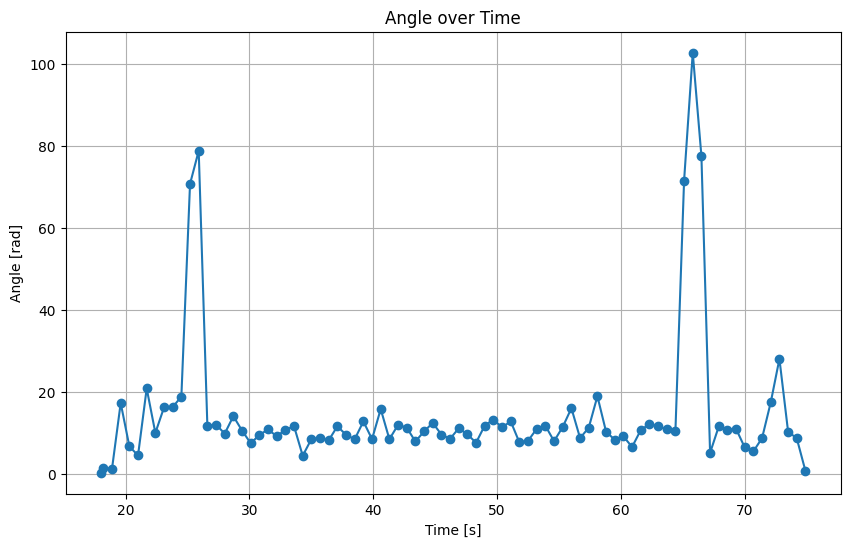

In [22]:
plot_data(data, angular_velocity_x)
plot_data_angular_velocity("x", angular_velocity_x, filtered_lowpass_angular_velocity_x)
# plot_data_angular_velocity("y", angular_velocity_y, filtered_lowpass_angular_velocity_y)
plot_angle(angle)
# angleをプロット
plot_angle(angle_unit_time)